# Guessing game

Loosely following Lazaridou et al. (2017).

In [1]:
import logging
log = logging.getLogger("game")
log.setLevel(logging.DEBUG)
import importlib

import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
#IMG_EMB_FILE = "data/imgnet-emb50-sample500.txt"
IMG_EMB_FILE = "data/imgnet-emb1000-sample500.txt"
N_SYMBOLS = 10
N_IMAGES = 2
EMB_SIZE = 50

In [3]:
from tools import load_emb
_, fnames, embs = load_emb(IMG_EMB_FILE)
IMG_SHAPE = embs[0].shape
IMG_N = len(embs)
IMG_SHAPE

Using TensorFlow backend.


(1000,)

## Set up model

In [1]:
import game.game as game
import agent.basic_reinforce as agent
importlib.reload(agent)
importlib.reload(game)

sender = agent.Sender(img_shape=IMG_SHAPE, 
                      n_images=N_IMAGES, 
                      n_symbols=N_SYMBOLS, 
                      embedding_size=EMB_SIZE)
receiver = agent.Receiver(img_shape=IMG_SHAPE, 
                          n_images=N_IMAGES, 
                          n_symbols=N_SYMBOLS, 
                          embedding_size=EMB_SIZE)
g = game.Game(images=embs, 
              images_filenames=fnames, 
              sender=sender, 
              receiver=receiver)
#sender.model.summary()
#receiver.model.summary()

Using TensorFlow backend.


NameError: name 'importlib' is not defined

<IPython.core.display.Javascript object>


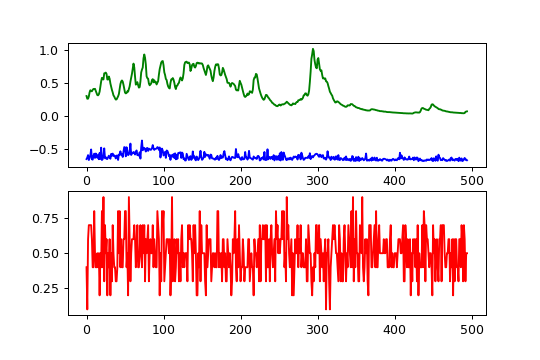

In [20]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
plt.ion()

fig.show()
fig.canvas.draw()

success_rate = []
sendr_loss = []
recvr_loss = []
success_rate_avg = 0
sendr_loss_avg = 0
recvr_loss_avg = 0
for i in range(5000):
    success_rate_avg += g.take_turn()
    sendr_loss_avg += sender.last_loss
    recvr_loss_avg += receiver.last_loss
    if i and not i % 10:
        success_rate.append(success_rate_avg/10)
        sendr_loss.append(sendr_loss_avg/10)
        recvr_loss.append(recvr_loss_avg/10)
        success_rate_avg = 0
        sendr_loss_avg = 0
        recvr_loss_avg = 0
    if not i % 50:
        ax1.clear()
        ax2.clear()
        ax1.plot(sendr_loss, "g")
        ax1.plot(recvr_loss, "b")
        ax2.plot(success_rate, "r")
        fig.canvas.draw()

In [ ]:
g.take_turn()

In [ ]:
np.random.choice(50)[0]